# Import Data

In [2]:
import pandas as pd
import numpy as np
#defining the class names
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
#importing the data
train = pd.read_csv("/Users/mallampati/Downloads/jigsaw-toxic-comment-classification-challenge/train.csv")
test = pd.read_csv('/Users/mallampati/Downloads/jigsaw-toxic-comment-classification-challenge/test.csv')

# Data Preprocessing

In [3]:
#checking for missing values:
print("checking for missing values in train data")
print(train.isnull().sum())

print("checking for missing data in test data")
print(test.isnull().sum())

checking for missing values in train data
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
checking for missing data in test data
id              0
comment_text    0
dtype: int64


### Data Visualization -- Class Distribution

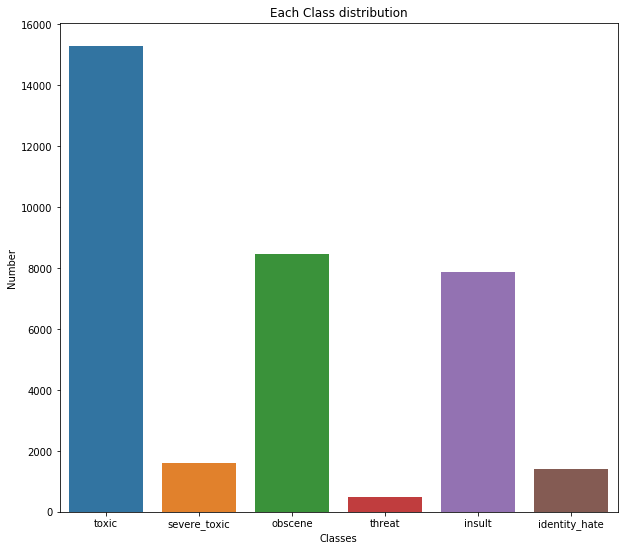

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

classes=train.iloc[:,2:].sum() # count of classes from toxic to identity hate 
plt.figure(figsize=(10,9))
sns.barplot(classes.index, classes.values)
plt.title("Each Class distribution")
plt.ylabel('Number')
plt.xlabel('Classes')
plt.show()

### Data Visualization -- Correlation Matrix

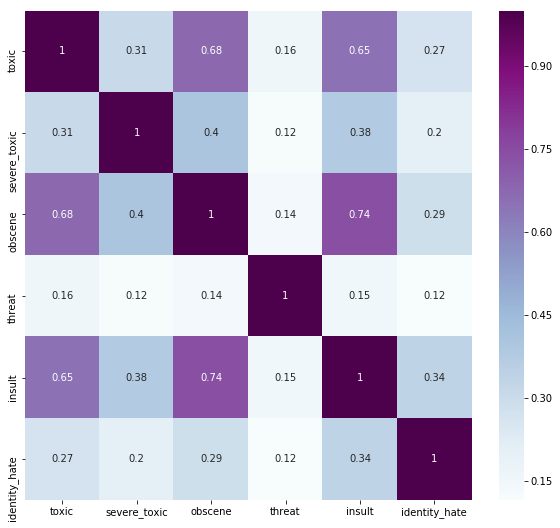

In [5]:
corr = train.iloc[:,2:].corr()
plt.figure(figsize=(10,9))
sns.heatmap(corr,xticklabels = corr.columns,yticklabels=corr.columns,annot= True,cmap="BuPu")

plt.show()

In [6]:
#determing output y values
test_y = train[class_names].values

#splitting into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(train, test_y, test_size = 0.1)


In [7]:
import keras
from keras.preprocessing.text import Tokenizer

#covert the text into lower case
X_train_lower = X_train["comment_text"].str.lower()
X_test_lower = X_test["comment_text"].str.lower()
test_lower = test["comment_text"].str.lower()

# remove stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

def clean_stopwords(text):
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text
X_train_lower = X_train_lower.apply(clean_stopwords)

#tokenizing 
max_features = 50000
tokenizer = Tokenizer(num_words = max_features,filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower = True,)
tokenizer.fit_on_texts(X_train_lower)
X_train["comment_seq"] = tokenizer.texts_to_sequences(X_train_lower)
X_test["comment_seq"] = tokenizer.texts_to_sequences(X_test_lower)
test["comment_seq"] = tokenizer.texts_to_sequences(test_lower)




Using TensorFlow backend.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mallampati/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/Users/mallampati/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mallampati/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
# converting sequences into a 2D Numpy array
maxlen=100
X_train=keras.preprocessing.sequence.pad_sequences(X_train.comment_seq, maxlen=maxlen, dtype='int32', padding='pre', truncating='pre', value=0.0)
X_test=keras.preprocessing.sequence.pad_sequences(X_test.comment_seq, maxlen=maxlen, dtype='int32', padding='pre', truncating='pre', value=0.0)
test = keras.preprocessing.sequence.pad_sequences(test.comment_seq, maxlen=maxlen, dtype='int32', padding='pre', truncating='pre', value=0.0)


In [10]:
# embedding GloVe (instead of W2v we are using GloVe(Global Vectors for Word Representation))
embedding_location = "/Users/mallampati/Downloads/jigsaw-toxic-comment-classification-challenge/data/crawl-300d-2M.vec"

def get_coefficients(word,*arr): 
      return word, np.asarray(arr, dtype='float32')

embed_index = dict(get_coefficients(*o.strip().split(" ")) for o in open(embedding_location,errors= 'ignore'))


word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embed_size = 300

embed_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features:
        continue
    embed_vector = embed_index.get(word)
    if embed_vector is not None: 
        embed_matrix[i] = embed_vector

# LSTM Model

In [11]:
from keras.models import Model,load_model
from keras.optimizers import RMSprop
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding ,SpatialDropout1D, Conv1D
from keras.layers import Bidirectional, GlobalMaxPooling1D, MaxPooling1D,GRU,concatenate,GlobalAveragePooling1D
from keras.models import Sequential

inp = Input(shape = (maxlen,))
# adding embedding layer
outputs = Embedding(max_features, embed_size, weights = [embed_matrix], trainable = False)(inp)

# adding dropout layer
outputs = SpatialDropout1D(0.2)(outputs)

# adding Recurrent layer
outputs = Bidirectional(GRU(128, return_sequences = True))(outputs)

# adding convolution layer
outputs = Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(outputs)

# concatination of maxpool and average max pool layers
outputs = concatenate([GlobalMaxPooling1D()(outputs),GlobalAveragePooling1D()(outputs)])

# add fully connected layers
outputs = Dense(128, activation='relu')(outputs)

outputs = Dropout(0.1)(outputs)
outputs = Dense(64, activation="relu")(outputs)
outputs = Dropout(0.1)(outputs)
outputs = Dense(6, activation="sigmoid")(outputs)

model = Model(inputs = inp,outputs = outputs)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     15000000    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 100, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidi

In [16]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model,load_model
epoch = 4
batch_size = 100

# with a constant learning rate 
MM=model.fit(X_train,Y_train,batch_size=batch_size, epochs=epoch, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)], validation_split=0.1)


Train on 129251 samples, validate on 14362 samples
Epoch 1/4
129251/129251 [==============================] - 2995s 23ms/step - loss: 0.0424 - acc: 0.9835 - val_loss: 0.0407 - val_acc: 0.9841
Epoch 2/4
129251/129251 [==============================] - 632s 5ms/step - loss: 0.0403 - acc: 0.9841 - val_loss: 0.0421 - val_acc: 0.9839
Epoch 3/4
129251/129251 [==============================] - 670s 5ms/step - loss: 0.0378 - acc: 0.9848 - val_loss: 0.0416 - val_acc: 0.9835
Epoch 4/4
129251/129251 [==============================] - 651s 5ms/step - loss: 0.0353 - acc: 0.9857 - val_loss: 0.0420 - val_acc: 0.9845


# Prediction

In [17]:
# predicting on test 
pred = model.predict(test, batch_size = 10, verbose = 1)

153164/153164 [==============================] - 482s 3ms/step


In [18]:
# accuracy of the model
accruracy = model.evaluate(X_test,Y_test)
print('Test data \n  Loss: {}\n  Accuracy: {}'.format(accruracy[0],accruracy[1]))

15958/15958 [==============================] - 31s 2ms/step
Test data 
  Loss: 0.04627001273694052
  Accuracy: 0.9835087821617776


### Evaluation with Visualization

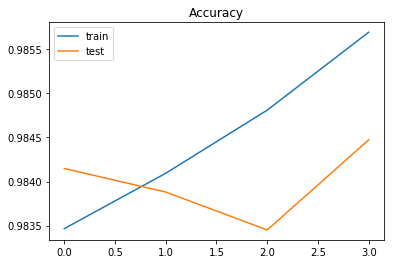

In [19]:
plt.title('Accuracy')
plt.plot(MM.history['acc'], label='train')
plt.plot(MM.history['val_acc'], label='test')
plt.legend()
plt.show();

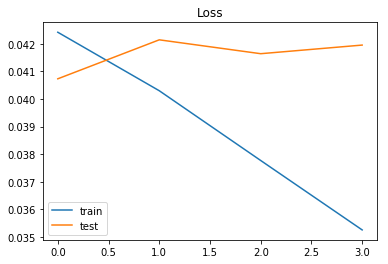

In [20]:
plt.title('Loss')
plt.plot(MM.history['loss'], label='train')
plt.plot(MM.history['val_loss'], label='test')
plt.legend()
plt.show();